In [120]:
import pandas as pd
import pickle
import numpy as np
from typing import Any, List
from dataclasses import dataclass

## Load the features

In [121]:
features_fp = '../../data/features/features_texas_florida.pkl'

@dataclass
class Feature:
    data: pd.DataFrame | np.ndarray
    col: str
    type: str
    model: Any | None
    params: dict | None

    def __str__(self):
        return f"{self.type} ({self.col}) - {self.params}"
    
    __repr__ = __str__


features: List[Feature] = pickle.load(open(features_fp, 'rb'))
features

[amenities (amenities) - {'corr_thresh': 0.05},
 amenities (amenities) - {'corr_thresh': None},
 embeddings (comments) - {'vector_size': 50},
 embeddings (description) - {'vector_size': 50},
 pca (comments) - {'n_components': 3, 'vector_size': 50},
 pca (description) - {'n_components': 3, 'vector_size': 50},
 pca (comments+amenities) - {'n_components': 3, 'vector_size': 50},
 pca (description+amenities) - {'n_components': 3, 'vector_size': 50},
 pca (comments) - {'n_components': 5, 'vector_size': 50},
 pca (description) - {'n_components': 5, 'vector_size': 50},
 pca (comments+amenities) - {'n_components': 5, 'vector_size': 50},
 pca (description+amenities) - {'n_components': 5, 'vector_size': 50},
 pca (comments) - {'n_components': 10, 'vector_size': 50},
 pca (description) - {'n_components': 10, 'vector_size': 50},
 pca (comments+amenities) - {'n_components': 10, 'vector_size': 50},
 pca (description+amenities) - {'n_components': 10, 'vector_size': 50},
 pca (comments) - {'n_component

## Break down the features into combinations we want to test

In [122]:
# get all unique feature types and col combinations
feature_types_col_combos = set([(f.type, f.col) for f in features])
feature_types_col_combos

{('amenities', 'amenities'),
 ('embeddings', 'comments'),
 ('embeddings', 'description'),
 ('pca', 'comments'),
 ('pca', 'comments+amenities'),
 ('pca', 'description'),
 ('pca', 'description+amenities')}

In [123]:
def get_features_by_type_and_col(feature_type: str, col: str="") -> List[Feature]:
    if col == "":
        col = feature_type
    return list(filter(lambda f: f.type == feature_type and f.col == col, features))

@dataclass
class ComboSet:
    name: str
    features: List[List[Feature]]

combos_sets = [
    ComboSet("Amenities and PCA",
             [
        get_features_by_type_and_col("amenities"), 
        get_features_by_type_and_col("pca", "comments"),
        get_features_by_type_and_col("pca", "description"),
    ]),
    ComboSet("Amenities and embeddings", [
        get_features_by_type_and_col("amenities"),
        get_features_by_type_and_col("embeddings", "comments"),
        get_features_by_type_and_col("embeddings", "description"),
    ]),
    ComboSet("PCA over amenities and embeddings", [
        get_features_by_type_and_col("pca", "comments+amenities"),
        get_features_by_type_and_col("pca", "description+amenities"),
    ])
]

## Train a KNN classifier on all combinations of features

### Load labels

In [124]:
# Read in the data
GEO = ["texas", "florida"]

if isinstance(GEO, str):
    df = pd.read_csv(f"../../data/processed/{GEO}_auto_processed.csv")
elif isinstance(GEO, list):
    dfs = []
    for geo in GEO:
        df = pd.read_csv(f"../../data/processed/{geo}_auto_processed.csv")
        df["source"] = geo
        dfs.append(df)
    df = pd.concat(dfs)

df.reset_index(drop=True, inplace=True)

labels = df.label
labels

0        good
1        good
2        good
3        good
4        good
        ...  
1541     mbad
1542     mbad
1543     mbad
1544    mgood
1545     mbad
Name: label, Length: 1546, dtype: object

In [127]:
# import KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import itertools
from sklearn.model_selection import train_test_split

def balance_data(data):

    oversample = SMOTE()
    X, y = oversample.fit_resample(data, labels)

    return X, y

def process_combo(combo):
    # Get the features
    features = [f.data for f in combo]

    # Combine the features
    X = np.concatenate(features, axis=1)

    # Balance the data
    X, y = balance_data(X)

    return X, y

log = []
def log_it(msg):
    print(msg)
    log.append(msg)

best_model = None
best_combo = None
best_accuracy = 0

i = 0
for combo_set in combos_sets:

    # get cartesian product of features
    for combo in itertools.product(*combo_set.features):

        i += 1
        log_it(f"{i}/1800 - {combo_set.name}: {combo}")

        X, y = process_combo(combo)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train the model
        knn = KNeighborsClassifier(**{'leaf_size': 10, 'n_neighbors': 3})
        knn.fit(X_train, y_train)

        # Get the accuracy
        accuracy = knn.score(X_test, y_test)
        # update the best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = knn
            best_combo = combo
            log_it(f"New Best Accuracy: {accuracy}")
        else:
            log_it(f"Accuracy: {accuracy} (best: {best_accuracy})")


log_it(f"Best Combo: {best_combo}")
log_it(f"Best Accuracy: {best_accuracy}")

save_fp = "../../models/knn_model.pkl"

# save the best model
pickle.dump({
    "model": best_model,
    "combo": best_combo,
}, open(save_fp, "wb"))

# save the log
with open("../../models/knn_model_log.txt", "w") as f:
    log_txt = "\n".join(log)
    f.write(log_txt)

print(f"Saved to {save_fp}")

1/1800 - Amenities and PCA: (amenities (amenities) - {'corr_thresh': 0.05}, pca (comments) - {'n_components': 3, 'vector_size': 50}, pca (description) - {'n_components': 3, 'vector_size': 50})
New Best Accuracy: 0.8998988877654196
2/1800 - Amenities and PCA: (amenities (amenities) - {'corr_thresh': 0.05}, pca (comments) - {'n_components': 3, 'vector_size': 50}, pca (description) - {'n_components': 5, 'vector_size': 50})
New Best Accuracy: 0.9049544994944388
3/1800 - Amenities and PCA: (amenities (amenities) - {'corr_thresh': 0.05}, pca (comments) - {'n_components': 3, 'vector_size': 50}, pca (description) - {'n_components': 10, 'vector_size': 50})
Accuracy: 0.8948432760364005 (best: 0.9049544994944388)
4/1800 - Amenities and PCA: (amenities (amenities) - {'corr_thresh': 0.05}, pca (comments) - {'n_components': 3, 'vector_size': 50}, pca (description) - {'n_components': 20, 'vector_size': 50})
Accuracy: 0.9009100101112234 (best: 0.9049544994944388)
5/1800 - Amenities and PCA: (amenities

## ExtraTrees????

In [131]:
from lazypredict.Supervised import LazyClassifier

X, y = process_combo(best_combo)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

models, predictions = clf.fit(X_train, X_test, y_train, y_test)

models

100%|██████████| 29/29 [00:12<00:00,  2.42it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.97,0.97,None,0.97,0.41
LGBMClassifier,0.95,0.95,None,0.95,0.57
RandomForestClassifier,0.95,0.95,None,0.95,1.33
LabelPropagation,0.92,0.92,None,0.92,0.77
LabelSpreading,0.92,0.92,None,0.92,1.11
SVC,0.91,0.91,None,0.91,0.53
BaggingClassifier,0.90,0.90,None,0.90,0.82
KNeighborsClassifier,0.86,0.86,None,0.85,0.05
NuSVC,0.85,0.85,None,0.85,0.92


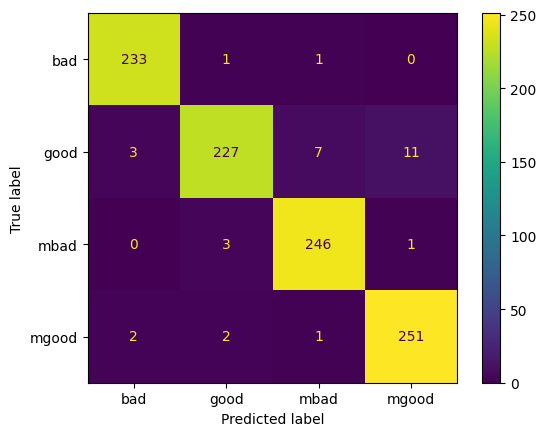

In [132]:
# Get the confusion matrix for the best model
X, y = process_combo(best_combo)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train an ExtraTreesClassifier on the best_combo
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(**{'bootstrap': False, 'max_depth': 80, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100})

clf.fit(X_train, y_train)

# get the predictions
y_pred = clf.predict(X_test)

# plot a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()